# TODO: Fix me before merging into main

In [1]:
%load_ext autoreload
%autoreload 2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# import jax; jax.config.update("jax_enable_x64", True)

In [2]:
from pyuff_ustb import Uff
from spekk import ops

ops.backend.set_backend("jax")

from vbeam.data_importers import PyUFFImporter
from vbeam.util.download import cached_download

data_url = "http://www.ustb.no/datasets/PICMUS_carotid_cross.uff"
uff = Uff(cached_download(data_url))
channel_data = uff.read("/channel_data")
scan = uff.read("/scan")
importer = PyUFFImporter(channel_data, scan)

/home/magnusk/pyuff/pyuff_ustb/objects/point.py:60: RuntimeWarning: invalid value encountered in multiply
  return self.distance * np.sin(self.elevation)
/home/magnusk/pyuff/pyuff_ustb/objects/point.py:56: RuntimeWarning: invalid value encountered in multiply
  return self.distance * np.sin(self.azimuth) * np.cos(self.elevation)


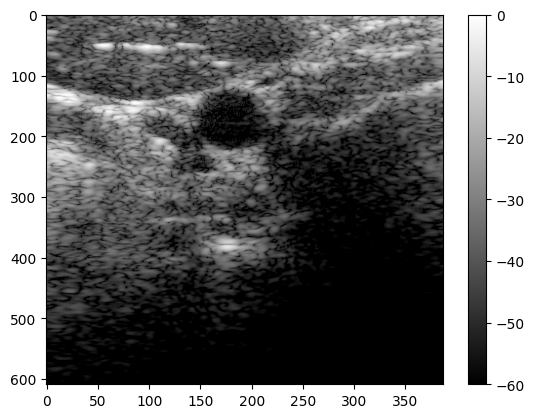

In [4]:
import matplotlib.pyplot as plt

from vbeam.core import Output, Setup, signal_for_point


@ops.jit
def bf(setup: Setup):
    result = signal_for_point(setup.slice_dim("tx")[0])
    for tx in range(1, setup.dim_size("tx")):
        result1 = signal_for_point(setup.slice_dim("tx")[tx])
        result = Output(
            result.value + result1.value,
            result.apodization + result1.apodization,
        )
    # result = signal_for_point(setup)
    dim_sum = tuple(set(result.value.dims) - {"x_axis", "z_axis", "frames"})
    value = ops.sum(result.value, axis=dim_sum)
    apodization_overlap = ops.sum(result.apodization, axis=dim_sum)
    value = value / apodization_overlap
    return 20 * ops.log10(ops.abs(value))


image = bf(importer.get_setup(0))
plt.imshow(image.T - ops.max(image), aspect="auto", cmap="gray", vmin=-60)
plt.colorbar()

In [10]:
setup = importer.get_setup(0)
%timeit bf(setup).data.block_until_ready()

181 ms ± 32.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
